In [1]:
# Code snippet for rendering animations in the docs
from IPython.display import HTML
import warnings
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
import matplotlib.pyplot as plt

def render_ani_func(f):
    om.utils.disable_interactive_backend_switching()
    plt.switch_backend('Agg')
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ani = f()
    %matplotlib inline
    om.utils.enable_interactive_backend_switching()

    vid = HTML(ani.to_html5_video())
    plt.close('all')
    return vid

```{tip}
Download this tutorial as a {download}`Jupyter notebook <converted/ratiometry.ipynb>`, or a {download}`python script <converted/ratiometry.py>` with code cells.
```

# Tutorial 3: Ratiometry

## Combining Numerical Motion Compensation and Ratiometry with Di-4-ANEPPS

In this tutorial, we will discuss the analysis of ratiometric optical mapping data. Numerical motion tracking and motion-stabilization alone cannot inhibit motion artifacts entirely. To achieve better motion artifact compensation, it is required to combine numerical motion tracking with ratiometric imaging, as described in Kappadan et al. (2020). In this example dataset, the heart was stained with Di-4-ANEPPS and imaged using an alternating green and blue illumination at 500fps. The tissue was illuminated in every odd frame with green light and in every even frame with blue light, respectively. This approach is sometimess referred to as 'excitation ratiometry'. After numerical motion tracking and stabilization, the green and blue videos are divided by each other to obtain a motion-stabilized ratiometric video. Using this method, both motion artifacts as well as illumination artifacts (which also lead to motion artifacts) can be significantly reduced. 

First, we load the video data, which is stored as a single file (`Example_05_Ratiometry.npy`) containing the two green and blue videos in an interleaved fashion (frame 1 = green, frame 2 = blue, frame 3 = green, etc.). Using optimap's `load_video()` function, we can specify to load only every 2nd frame and to start reading from the first or the second frame, respectively:

In [5]:
import optimap as om
# import monochrome as mc  # remove this if you don't have monochrome installed

filename = om.utils.retrieve_example_data('Example_05_Ratiometry.npy')
#filename = 'example_data/Example_05_Ratiometry.npy'
video_blue = om.load_video(filename, start_frame=0, step=2)
video_green = om.load_video(filename, start_frame=1, step=2)

om.print_properties(video_blue)
om.print_properties(video_green)


------------------------------------------------------------------------------------------
array with dimensions: (600, 128, 128)
datatype of array: uint16
minimum value in entire array: 606
maximum value in entire array: 29340
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
array with dimensions: (600, 128, 128)
datatype of array: uint16
minimum value in entire array: 688
maximum value in entire array: 30556
------------------------------------------------------------------------------------------


Alternatively, one could load the video and manually split the video into the green and blue videos (`video_green = video[::2,:,:]` etc.). Both videos contain 'uint16' intensity values in each pixel, which means that they can have whole unsigned integer values between 0 and 65535. The videos dimensions are 128 x 128 pixels and each video contains 600 frames. The original interleaved video contains 1200 frames. The green video is only slightly brighter based on the maximum value.

When we play the two videos next to each other we notice that there is signal in only the green video but not in the blue video:

In [2]:
om.video.play2(video_green, video_blue, title1="green video with signal", title2="blue video without signal");

In [ ]:
render_ani_func(lambda: om.video.play2(video_green, 1, title="green video with signal", interval=20))

If we plot and compare two optical traces from the green and blue videos respectively, we can see in most areas stronger intensity fluctuations in the green video:

In [3]:
om.trace.set_default_trace_window('disc') # the trace is sample from a disc-shaped region with a diameter specified by 'size'
om.compare_traces([video_green, video_blue],labels=['green','blue'], size=5, colors=['green','blue'])

Keep in mind that the motion in both videos is not compensated yet and produces strong motion artifacts. In the green video, the intensity fluctuations are caused in parts by motion and in parts by the optical signal related to the action potential. In the blue video, nearly all fluctuations are caused by motion. Let's look at a few specific examples. Above, the function ``compare_traces()`` was started in interactive mode because we did not provide specific coordinates as arguments. We can also provide specific coordinates, e.g. the pixel at (50,50) or a list of pixels, as follows:

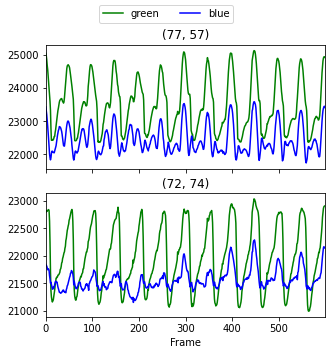

In [4]:
om.compare_traces([video_green, video_blue],[(77, 57), (72, 74)],labels=['green','blue'], size=5, colors=['green', 'blue'])

In these two examples, the green optical trace shows steep downstrokes which is typical for the upstroke of the action potential, whereas the blue trace exhibits much weaker and inconsistent intensity fluctuations. These fluctuations are largely caused by motion.

In [12]:
traces_blue, positions = om.select_traces(video_blue)
traces_green = om.extract_traces(video_green, positions)

Now let's perform numerical motion tracking and motion-stabilization with the green and blue videos:

In [16]:
video_warped_green = om.motion_compensate(video_green, contrast_kernel=5, ref_frame=0)
video_warped_blue = om.motion_compensate(video_blue, contrast_kernel=5, ref_frame=0)
om.video.playn([video_green, video_warped_green, video_blue, video_warped_blue],
               titles=["video green", "stabilized video green", "video blue", "stabilized video blue"], figsize=(8, 3.5));

calculating flows (GPU): 100%|██████████| 600/600 [00:00<00:00, 1365.32it/s]


In the comparison above you can see that both the green and blue videos were succesfully tracked and warped (motion-stabilized). There is no residual motion after warping and there are no tracking artifacts. The function ``motion_compensate()`` computed a contrast-enhanced video, registered / tracked and stabilized the motion / warped the original video. Now let's look at how the green and blue traces have changed after the motion-stabilization:

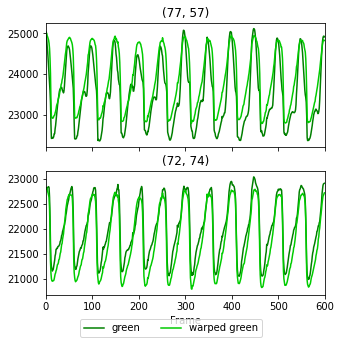

In [22]:
om.compare_traces([video_green, video_warped_green],[(77, 57), (72, 74)],labels=['green','warped green'], size=5, colors=['green', [0, 0.8, 0]])

We plotted the motion-stabilized green trace slightly darker than the original green trace.

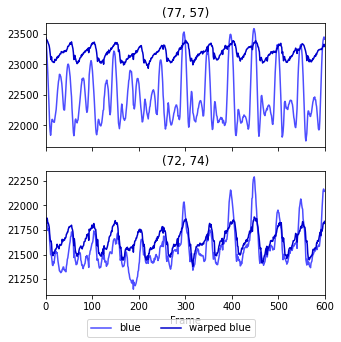

In [20]:
om.compare_traces([video_blue, video_warped_blue],[(77, 57), (72, 74)],labels=['blue','warped blue'], size=5, colors=[[0.3, 0.3, 1], [0, 0, 0.8]])

We plotted the motion-stabilized blue trace in dark blue and the original trace in light/grey blue.

In [18]:
om.compare_traces([video_green, video_warped_green],labels=['green','warped green'], size=5, colors=['green', [0, 0.8, 0]])